In [451]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re

# max_num_seq

In [452]:
ROOT = Path(".").resolve()
RUNS_DIR = ROOT / "runs_max_num_seq"
assert RUNS_DIR.exists(), f"Impossible de trouver {RUNS_DIR}"

def extract_run_id(path: Path) -> int:
    m = re.search(r"(\d+)", path.name)
    if not m:
        raise ValueError(f"Pas de chiffre dans le nom du dossier: {path.name}")
    return int(m.group(1))

# --- 1) Forcer les 10 runs attendus: 2..11 ---
target_run_ids = list(range(2, 12))  # 2..11 inclus
run_dirs = [d for d in RUNS_DIR.iterdir() if d.is_dir() and extract_run_id(d) in target_run_ids]
run_dirs = sorted(run_dirs, key=extract_run_id)

run_ids = [extract_run_id(d) for d in run_dirs]
print("Runs détectés (run_id):", run_ids)
assert run_ids == target_run_ids, f"Attention: runs attendus {target_run_ids} mais trouvés {run_ids}"

# --- 2) Mapping run_idx -> max_num_seq ---
max_num_seq_list = [32, 48, 64, 80, 96, 128, 160, 192, 224, 256]

meta = pd.DataFrame({
    "run_dir": run_dirs,
    "run_id": run_ids,
    "run_idx": list(range(1, 11)),
    "max_num_seq": max_num_seq_list
})

# --- 3) Helpers de lecture ---
def read_csv_with_meta(path: Path, r):
    df = pd.read_csv(path)

    # écraser/ajouter sans erreur même si les colonnes existent déjà
    df["run_id"] = int(r["run_id"])
    df["run_idx"] = int(r["run_idx"])
    df["max_num_seq"] = int(r["max_num_seq"])

    # remettre les 3 colonnes en tête
    front = ["run_id", "run_idx", "max_num_seq"]
    df = df[front + [c for c in df.columns if c not in front]]
    return df


def build_df_fixed(filename: str):
    parts = []
    missing = []
    for _, r in meta.iterrows():
        f = Path(r["run_dir"]) / filename
        if not f.exists():
            missing.append((r["run_id"], str(f)))
            continue
        parts.append(read_csv_with_meta(f, r))
    df = pd.concat(parts, ignore_index=True) if parts else pd.DataFrame()
    return df, missing

def build_df_memory():
    parts = []
    missing = []
    for _, r in meta.iterrows():
        # on cherche le fichier mémoire correspondant au run_id
        expected = f"memory-GPT-run-{r['run_id']}.csv"
        f = Path(r["run_dir"]) / expected

        # fallback si jamais le nom diffère légèrement
        if not f.exists():
            candidates = list(Path(r["run_dir"]).glob("memory-GPT-run-*.csv"))
            # essayer de matcher le run_id dans le nom
            pick = None
            for c in candidates:
                m = re.search(r"memory-GPT-run-(\d+)\.csv$", c.name)
                if m and int(m.group(1)) == int(r["run_id"]):
                    pick = c
                    break
            f = pick if pick else f

        if not f.exists():
            missing.append((r["run_id"], str(f)))
            continue

        parts.append(read_csv_with_meta(f, r))

    df = pd.concat(parts, ignore_index=True) if parts else pd.DataFrame()
    return df, missing

# --- 4) Construire les 4 DF ---
accuracy_df, miss_acc = build_df_fixed("accuracy_metrics.csv")
perf_df,     miss_perf = build_df_fixed("perf_full.csv")
memsum_df,   miss_memsum = build_df_fixed("memory_summary.csv")
memory_df,   miss_memory = build_df_memory()

dfs_by_csv = {
    "accuracy_metrics": accuracy_df,
    "perf_full": perf_df,
    "memory_summary": memsum_df,
    "memory": memory_df
}


Runs détectés (run_id): [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


In [453]:
perf_df = dfs_by_csv["perf_full"]
accuracy_df = dfs_by_csv["accuracy_metrics"]
mem_sum_df = dfs_by_csv["memory_summary"]
memory_df = dfs_by_csv["memory"]

In [454]:

def fix_memory_df(memory_df: pd.DataFrame) -> pd.DataFrame:
    df = memory_df.copy()

    # --- Détection du "shift" (pod contient en fait 0/1 et utc_ts contient un nom de pod)
    pod_is_gpu = pd.to_numeric(df["pod"], errors="coerce").notna().mean() > 0.7
    utc_looks_like_podname = df["utc_ts"].astype(str).str.contains("vllm", na=False).mean() > 0.3
    temp_mostly_nan = df.get("temp_C", pd.Series([pd.NA]*len(df))).isna().mean() > 0.7

    if pod_is_gpu and utc_looks_like_podname and temp_mostly_nan:
        # Sauvegarde dans des colonnes temporaires (AUCUNE collision de noms)
        df["_pod_fix"]        = df["utc_ts"]
        df["_gpu_index_fix"]  = df["pod"]
        df["_mem_used_fix"]   = df["gpu_index"]
        df["_mem_total_fix"]  = df["mem_used_MiB"]
        df["_gpu_util_fix"]   = df["mem_total_MiB"]
        df["_mem_util_fix"]   = df["gpu_util_pct"]
        df["_power_fix"]      = df["mem_util_pct"]
        df["_temp_fix"]       = df["power_W"]

        # Ré-écriture "propre"
        df["pod"]           = df["_pod_fix"]
        df["gpu_index"]     = df["_gpu_index_fix"]
        df["mem_used_MiB"]  = df["_mem_used_fix"]
        df["mem_total_MiB"] = df["_mem_total_fix"]
        df["gpu_util_pct"]  = df["_gpu_util_fix"]
        df["mem_util_pct"]  = df["_mem_util_fix"]
        df["power_W"]       = df["_power_fix"]
        df["temp_C"]        = df["_temp_fix"]

        # utc_ts n'existe pas vraiment dans le csv => on met NaT
        df["utc_ts"] = pd.NaT

        # drop temporaires
        df.drop(columns=[c for c in df.columns if c.endswith("_fix")], inplace=True)

    # --- Cast numérique robuste même si colonnes dupliquées existent déjà
    num_cols = ["gpu_index","mem_used_MiB","mem_total_MiB","gpu_util_pct","mem_util_pct","power_W","temp_C"]
    for c in num_cols:
        if c not in df.columns:
            continue
        x = df.loc[:, c]  # peut être Series OU DataFrame si colonnes dupliquées
        if isinstance(x, pd.DataFrame):
            df.loc[:, x.columns] = x.apply(pd.to_numeric, errors="coerce")
            # si duplicates, garder la 1ère colonne et supprimer les autres
            first = x.columns[0]
            df[c] = df[first]
            df.drop(columns=list(x.columns[1:]), inplace=True)
        else:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    # virer INFO/END etc. => gpu_index non num / NaN
    df = df[df["gpu_index"].notna()].reset_index(drop=True)

    return df


memory_df = fix_memory_df(memory_df)


In [455]:
# 1) Split metric -> metric_name + filter_name
accuracy_df = accuracy_df.copy()
tmp = accuracy_df["metric"].astype(str).str.split(",", n=1, expand=True)

accuracy_df["metric_name"] = tmp[0].str.strip()
accuracy_df["filter_name"] = tmp[1].fillna("").str.strip()

# 2) Label court pour plots (lisible)
metric_short_map = {
    "acc": "acc",
    "acc_norm": "acc_norm",
    "acc_stderr": "acc_se",
    "acc_norm_stderr": "acc_norm_se",
    "exact_match": "em",
    "exact_match_stderr": "em_se",
}

filter_short_map = {
    "none": "",
    "strict-match": "strict",
    "flexible-extract": "flex",
    "strict-match ": "strict",
    "flexible-extract ": "flex",
}

accuracy_df["metric_short"] = accuracy_df["metric_name"].map(metric_short_map).fillna(accuracy_df["metric_name"])
accuracy_df["filter_short"] = accuracy_df["filter_name"].map(filter_short_map).fillna(accuracy_df["filter_name"])

# ex: "acc_norm" ou "em_flex" etc.
accuracy_df["metric_plot"] = (
    accuracy_df["metric_short"]
    + accuracy_df["filter_short"].replace("", pd.NA).radd("_").fillna("")
)

# 3) Optionnel: ordre pour plots
metric_order = ["acc", "acc_norm", "acc_se", "acc_norm_se", "em", "em_flex", "em_se", "em_se_flex"]
accuracy_df["metric_plot"] = pd.Categorical(accuracy_df["metric_plot"], categories=metric_order, ordered=True)


C:\Users\badis\AppData\Local\Temp\ipykernel_29648\1912899128.py:37: Pandas4Warning: Constructing a Categorical with a dtype and values containing non-null entries not in that dtype's categories is deprecated and will raise in a future version.
  accuracy_df["metric_plot"] = pd.Categorical(accuracy_df["metric_plot"], categories=metric_order, ordered=True)


In [456]:
perf_df.drop(["run_id", "endpoint", "mode","model","probe_n_requests","probe_concurrency","probe_timeout_s",
              "sum_total_tokens","sum_completion_tokens","ok","failed","probe_max_tokens","sum_prompt_tokens"], axis=1, inplace=True)
mem_sum_df.drop(["run_id","util_p95_pct","mem_total_MiB","util_max_pct","source_file"], axis=1, inplace=True)
accuracy_df.drop(["run_id","metric","metric_plot","filter_short","metric_short","filter_name"], axis=1, inplace=True)
memory_df.drop(["run_id","utc_ts","mem_total_MiB","pod"], axis=1, inplace=True)
memory_df.dropna(inplace=True)

In [457]:
sns.set_theme(style="whitegrid")

# ---------- MEMORY (run-level) ----------
mem_run = (
    mem_sum_df
    .groupby(["run_idx","max_num_seq"], as_index=False)
    .agg(
        mem_used_max_MiB=("mem_used_max_MiB","max"),   # worst GPU
        mem_used_mean_MiB=("mem_used_mean_MiB","mean") # avg over GPUs
    )
)
mem_run["mem_max_GiB"]  = mem_run["mem_used_max_MiB"] / 1024
mem_run["mem_mean_GiB"] = mem_run["mem_used_mean_MiB"] / 1024


# ---------- ACCURACY : garder les métriques "principales" ----------
acc = accuracy_df.copy()

# Si jamais tu as aussi filter_name (selon ton split précédent), on le garde ; sinon on met "none"
if "filter_name" not in acc.columns:
    acc["filter_name"] = "none"

# enlever stderr
acc_main = acc[~acc["metric_name"].str.contains("stderr", na=False)].copy()

# choix des métriques par task:
# - arc_challenge : acc_norm
# - hellaswag     : acc_norm
# - gsm8k         : exact_match (flex si dispo sinon strict si dispo sinon exact_match)
# - truthfulqa_mc2: acc
# - winogrande    : acc

def pick_gsm_filter(df):
    if (df["filter_name"] == "flexible-extract").any():
        return "flexible-extract"
    if (df["filter_name"] == "strict-match").any():
        return "strict-match"
    return df["filter_name"].iloc[0]  # fallback

gsm_filter = pick_gsm_filter(
    acc_main[(acc_main.task=="gsm8k") & (acc_main.metric_name=="exact_match")]
) if ((acc_main.task=="gsm8k") & (acc_main.metric_name=="exact_match")).any() else "none"

acc_keep = pd.concat([
    acc_main[(acc_main.task=="arc_challenge")  & (acc_main.metric_name=="acc_norm")],
    acc_main[(acc_main.task=="hellaswag")      & (acc_main.metric_name=="acc_norm")],
    acc_main[(acc_main.task=="gsm8k")          & (acc_main.metric_name=="exact_match") & (acc_main.filter_name==gsm_filter)],
    acc_main[(acc_main.task=="truthfulqa_mc2") & (acc_main.metric_name=="acc")],
    acc_main[(acc_main.task=="winogrande")     & (acc_main.metric_name=="acc")],
], ignore_index=True)


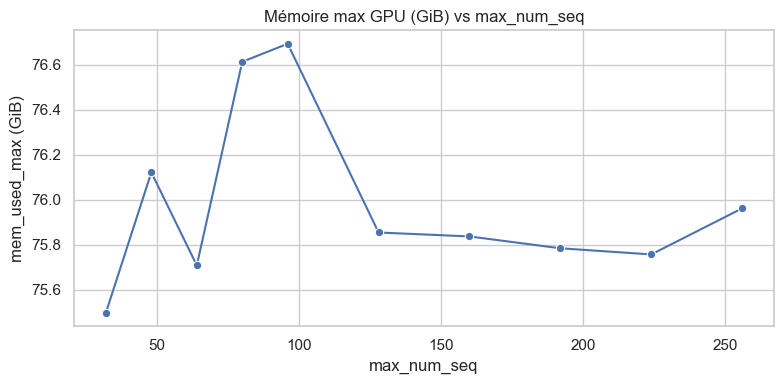

In [458]:
plt.figure(figsize=(8,4))
sns.lineplot(data=mem_run.sort_values("max_num_seq"), x="max_num_seq", y="mem_max_GiB", marker="o")
plt.title("Mémoire max GPU (GiB) vs max_num_seq")
plt.xlabel("max_num_seq")
plt.ylabel("mem_used_max (GiB)")
plt.tight_layout()
plt.show()


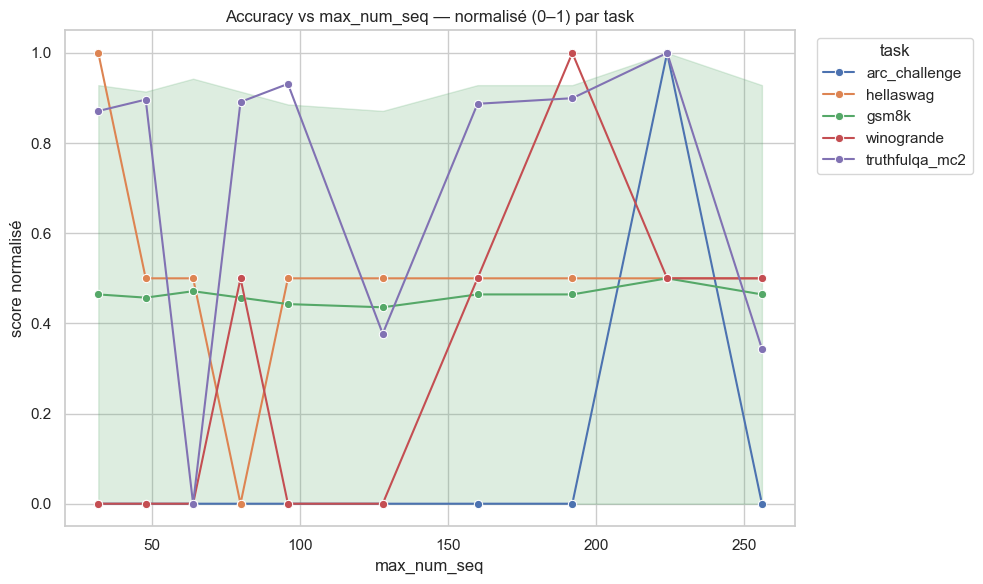

In [459]:
acc_plot = acc_keep.copy()

# normalisation min-max par task
acc_plot["value_norm"] = acc_plot.groupby("task")["value"].transform(
    lambda s: (s - s.min()) / (s.max() - s.min()) if (s.max() - s.min()) != 0 else 0.5
)

plt.figure(figsize=(10,6))
sns.lineplot(
    data=acc_plot.sort_values("max_num_seq"),
    x="max_num_seq", y="value_norm",
    hue="task",
    marker="o"
)
plt.title("Accuracy vs max_num_seq — normalisé (0–1) par task")
plt.xlabel("max_num_seq")
plt.ylabel("score normalisé")
plt.legend(title="task", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()



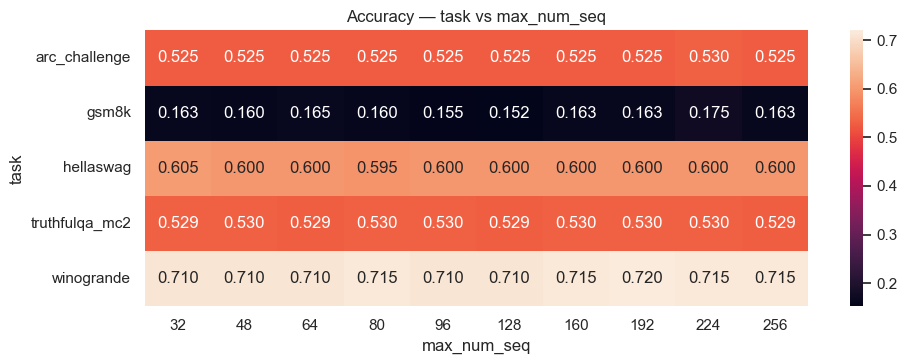

In [460]:
heat = acc_keep.pivot_table(index="task", columns="max_num_seq", values="value", aggfunc="mean")
plt.figure(figsize=(10,3.8))
sns.heatmap(heat, annot=True, fmt=".3f", cbar=True)
plt.title("Accuracy — task vs max_num_seq")
plt.xlabel("max_num_seq")
plt.ylabel("task")
plt.tight_layout()
plt.show()


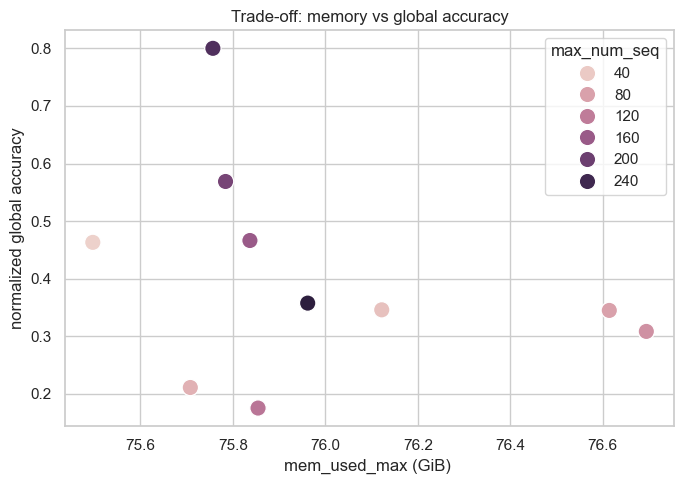

In [461]:
# wide: une colonne par task
acc_wide = acc_keep.pivot_table(index=["run_idx","max_num_seq"], columns="task", values="value", aggfunc="mean")

# normalisation min-max par task (pour comparer des métriques différentes)
acc_norm = (acc_wide - acc_wide.min()) / (acc_wide.max() - acc_wide.min())
acc_norm["acc_global_norm"] = acc_norm.mean(axis=1)

acc_global = acc_norm["acc_global_norm"].reset_index()

trade = mem_run.merge(acc_global, on=["run_idx","max_num_seq"], how="inner").sort_values("mem_max_GiB")

plt.figure(figsize=(7,5))
sns.scatterplot(data=trade, x="mem_max_GiB", y="acc_global_norm", hue="max_num_seq", s=140)
plt.title("Trade-off: memory vs global accuracy")
plt.xlabel("mem_used_max (GiB) ")
plt.ylabel("normalized global accuracy")
plt.tight_layout()
plt.show()


# max_num_bached_tok

In [462]:
ROOT = Path(".").resolve()
RUNS_DIR = ROOT / "runs_max_num_bached_tok"
assert RUNS_DIR.exists(), f"Impossible de trouver {RUNS_DIR}"

def extract_run_id(path: Path) -> int:
    m = re.search(r"(\d+)", path.name)
    if not m:
        raise ValueError(f"Pas de chiffre dans le nom du dossier: {path.name}")
    return int(m.group(1))

# --- 1) Forcer les 10 runs attendus: 2..11 ---
target_run_ids = list(range(1, 11))  # 2..11 inclus
run_dirs = [d for d in RUNS_DIR.iterdir() if d.is_dir() and extract_run_id(d) in target_run_ids]
run_dirs = sorted(run_dirs, key=extract_run_id)

run_ids = [extract_run_id(d) for d in run_dirs]
print("Runs détectés (run_id):", run_ids)
assert run_ids == target_run_ids, f"Attention: runs attendus {target_run_ids} mais trouvés {run_ids}"

# --- 2) Mapping run_idx -> max_num_seq ---
max_num_bached_tok_list = [8192,12288,16384,24576,32768,40960,49152,65536,81920,98304]

meta = pd.DataFrame({
    "run_dir": run_dirs,
    "run_id": run_ids,
    "run_idx": list(range(1, 11)),
    "max_num_bached_tok": max_num_bached_tok_list
})

# --- 3) Helpers de lecture ---
def read_csv_with_meta(path: Path, r):
    df = pd.read_csv(path)

    # écraser/ajouter sans erreur même si les colonnes existent déjà
    df["run_id"] = int(r["run_id"])
    df["run_idx"] = int(r["run_idx"])
    df["max_num_bached_tok"] = int(r["max_num_bached_tok"])

    # remettre les 3 colonnes en tête
    front = ["run_id", "run_idx", "max_num_bached_tok"]
    df = df[front + [c for c in df.columns if c not in front]]
    return df


def build_df_fixed(filename: str):
    parts = []
    missing = []
    for _, r in meta.iterrows():
        f = Path(r["run_dir"]) / filename
        if not f.exists():
            missing.append((r["run_id"], str(f)))
            continue
        parts.append(read_csv_with_meta(f, r))
    df = pd.concat(parts, ignore_index=True) if parts else pd.DataFrame()
    return df, missing

def build_df_memory():
    parts = []
    missing = []
    for _, r in meta.iterrows():
        # on cherche le fichier mémoire correspondant au run_id
        expected = f"memory-GPT-run-{r['run_id']}.csv"
        f = Path(r["run_dir"]) / expected

        # fallback si jamais le nom diffère légèrement
        if not f.exists():
            candidates = list(Path(r["run_dir"]).glob("memory-GPT-run-*.csv"))
            # essayer de matcher le run_id dans le nom
            pick = None
            for c in candidates:
                m = re.search(r"memory-GPT-run-(\d+)\.csv$", c.name)
                if m and int(m.group(1)) == int(r["run_id"]):
                    pick = c
                    break
            f = pick if pick else f

        if not f.exists():
            missing.append((r["run_id"], str(f)))
            continue

        parts.append(read_csv_with_meta(f, r))

    df = pd.concat(parts, ignore_index=True) if parts else pd.DataFrame()
    return df, missing

# --- 4) Construire les 4 DF ---
accuracy_df, miss_acc = build_df_fixed("accuracy_metrics.csv")
perf_df,     miss_perf = build_df_fixed("perf_full.csv")
memsum_df,   miss_memsum = build_df_fixed("memory_summary.csv")
memory_df,   miss_memory = build_df_memory()

dfs_by_csv = {
    "accuracy_metrics": accuracy_df,
    "perf_full": perf_df,
    "memory_summary": memsum_df,
    "memory": memory_df
}


Runs détectés (run_id): [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [463]:
perf_df = dfs_by_csv["perf_full"]
accuracy_df = dfs_by_csv["accuracy_metrics"]
mem_sum_df = dfs_by_csv["memory_summary"]
memory_df = dfs_by_csv["memory"]

In [464]:

def fix_memory_df(memory_df: pd.DataFrame) -> pd.DataFrame:
    df = memory_df.copy()

    # --- Détection du "shift" (pod contient en fait 0/1 et utc_ts contient un nom de pod)
    pod_is_gpu = pd.to_numeric(df["pod"], errors="coerce").notna().mean() > 0.7
    utc_looks_like_podname = df["utc_ts"].astype(str).str.contains("vllm", na=False).mean() > 0.3
    temp_mostly_nan = df.get("temp_C", pd.Series([pd.NA]*len(df))).isna().mean() > 0.7

    if pod_is_gpu and utc_looks_like_podname and temp_mostly_nan:
        # Sauvegarde dans des colonnes temporaires (AUCUNE collision de noms)
        df["_pod_fix"]        = df["utc_ts"]
        df["_gpu_index_fix"]  = df["pod"]
        df["_mem_used_fix"]   = df["gpu_index"]
        df["_mem_total_fix"]  = df["mem_used_MiB"]
        df["_gpu_util_fix"]   = df["mem_total_MiB"]
        df["_mem_util_fix"]   = df["gpu_util_pct"]
        df["_power_fix"]      = df["mem_util_pct"]
        df["_temp_fix"]       = df["power_W"]

        # Ré-écriture "propre"
        df["pod"]           = df["_pod_fix"]
        df["gpu_index"]     = df["_gpu_index_fix"]
        df["mem_used_MiB"]  = df["_mem_used_fix"]
        df["mem_total_MiB"] = df["_mem_total_fix"]
        df["gpu_util_pct"]  = df["_gpu_util_fix"]
        df["mem_util_pct"]  = df["_mem_util_fix"]
        df["power_W"]       = df["_power_fix"]
        df["temp_C"]        = df["_temp_fix"]

        # utc_ts n'existe pas vraiment dans le csv => on met NaT
        df["utc_ts"] = pd.NaT

        # drop temporaires
        df.drop(columns=[c for c in df.columns if c.endswith("_fix")], inplace=True)

    # --- Cast numérique robuste même si colonnes dupliquées existent déjà
    num_cols = ["gpu_index","mem_used_MiB","mem_total_MiB","gpu_util_pct","mem_util_pct","power_W","temp_C"]
    for c in num_cols:
        if c not in df.columns:
            continue
        x = df.loc[:, c]  # peut être Series OU DataFrame si colonnes dupliquées
        if isinstance(x, pd.DataFrame):
            df.loc[:, x.columns] = x.apply(pd.to_numeric, errors="coerce")
            # si duplicates, garder la 1ère colonne et supprimer les autres
            first = x.columns[0]
            df[c] = df[first]
            df.drop(columns=list(x.columns[1:]), inplace=True)
        else:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    # virer INFO/END etc. => gpu_index non num / NaN
    df = df[df["gpu_index"].notna()].reset_index(drop=True)

    return df


memory_df = fix_memory_df(memory_df)


In [465]:
# 1) Split metric -> metric_name + filter_name
accuracy_df = accuracy_df.copy()
tmp = accuracy_df["metric"].astype(str).str.split(",", n=1, expand=True)

accuracy_df["metric_name"] = tmp[0].str.strip()
accuracy_df["filter_name"] = tmp[1].fillna("").str.strip()

# 2) Label court pour plots (lisible)
metric_short_map = {
    "acc": "acc",
    "acc_norm": "acc_norm",
    "acc_stderr": "acc_se",
    "acc_norm_stderr": "acc_norm_se",
    "exact_match": "em",
    "exact_match_stderr": "em_se",
}

filter_short_map = {
    "none": "",
    "strict-match": "strict",
    "flexible-extract": "flex",
    "strict-match ": "strict",
    "flexible-extract ": "flex",
}

accuracy_df["metric_short"] = accuracy_df["metric_name"].map(metric_short_map).fillna(accuracy_df["metric_name"])
accuracy_df["filter_short"] = accuracy_df["filter_name"].map(filter_short_map).fillna(accuracy_df["filter_name"])

# ex: "acc_norm" ou "em_flex" etc.
accuracy_df["metric_plot"] = (
    accuracy_df["metric_short"]
    + accuracy_df["filter_short"].replace("", pd.NA).radd("_").fillna("")
)

# 3) Optionnel: ordre pour plots
metric_order = ["acc", "acc_norm", "acc_se", "acc_norm_se", "em", "em_flex", "em_se", "em_se_flex"]
accuracy_df["metric_plot"] = pd.Categorical(accuracy_df["metric_plot"], categories=metric_order, ordered=True)


C:\Users\badis\AppData\Local\Temp\ipykernel_29648\1912899128.py:37: Pandas4Warning: Constructing a Categorical with a dtype and values containing non-null entries not in that dtype's categories is deprecated and will raise in a future version.
  accuracy_df["metric_plot"] = pd.Categorical(accuracy_df["metric_plot"], categories=metric_order, ordered=True)


In [466]:
perf_df.drop(["run_id", "endpoint", "mode","model","probe_n_requests","probe_concurrency","probe_timeout_s",
              "sum_total_tokens","sum_completion_tokens","ok","failed","probe_max_tokens","sum_prompt_tokens"], axis=1, inplace=True)
mem_sum_df.drop(["run_id","util_p95_pct","mem_total_MiB","util_max_pct","source_file"], axis=1, inplace=True)
accuracy_df.drop(["run_id","metric","metric_plot","filter_short","metric_short","filter_name"], axis=1, inplace=True)
memory_df.drop(["run_id","utc_ts","mem_total_MiB","pod"], axis=1, inplace=True)
memory_df.dropna(inplace=True)

In [467]:
sns.set_theme(style="whitegrid")

# ---------- MEMORY (run-level) ----------
mem_run = (
    mem_sum_df
    .groupby(["run_idx","max_num_bached_tok"], as_index=False)
    .agg(
        mem_used_max_MiB=("mem_used_max_MiB","max"),   # worst GPU
        mem_used_mean_MiB=("mem_used_mean_MiB","mean") # avg over GPUs
    )
)
mem_run["mem_max_GiB"]  = mem_run["mem_used_max_MiB"] / 1024
mem_run["mem_mean_GiB"] = mem_run["mem_used_mean_MiB"] / 1024


# ---------- ACCURACY : garder les métriques "principales" ----------
acc = accuracy_df.copy()

# Si jamais tu as aussi filter_name (selon ton split précédent), on le garde ; sinon on met "none"
if "filter_name" not in acc.columns:
    acc["filter_name"] = "none"

# enlever stderr
acc_main = acc[~acc["metric_name"].str.contains("stderr", na=False)].copy()

# choix des métriques par task:
# - arc_challenge : acc_norm
# - hellaswag     : acc_norm
# - gsm8k         : exact_match (flex si dispo sinon strict si dispo sinon exact_match)
# - truthfulqa_mc2: acc
# - winogrande    : acc

def pick_gsm_filter(df):
    if (df["filter_name"] == "flexible-extract").any():
        return "flexible-extract"
    if (df["filter_name"] == "strict-match").any():
        return "strict-match"
    return df["filter_name"].iloc[0]  # fallback

gsm_filter = pick_gsm_filter(
    acc_main[(acc_main.task=="gsm8k") & (acc_main.metric_name=="exact_match")]
) if ((acc_main.task=="gsm8k") & (acc_main.metric_name=="exact_match")).any() else "none"

acc_keep = pd.concat([
    acc_main[(acc_main.task=="arc_challenge")  & (acc_main.metric_name=="acc_norm")],
    acc_main[(acc_main.task=="hellaswag")      & (acc_main.metric_name=="acc_norm")],
    acc_main[(acc_main.task=="gsm8k")          & (acc_main.metric_name=="exact_match") & (acc_main.filter_name==gsm_filter)],
    acc_main[(acc_main.task=="truthfulqa_mc2") & (acc_main.metric_name=="acc")],
    acc_main[(acc_main.task=="winogrande")     & (acc_main.metric_name=="acc")],
], ignore_index=True)


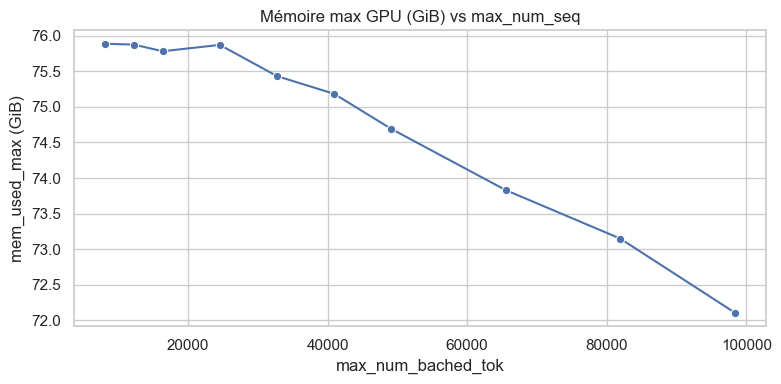

In [468]:
plt.figure(figsize=(8,4))
sns.lineplot(data=mem_run.sort_values("max_num_bached_tok"), x="max_num_bached_tok", y="mem_max_GiB", marker="o")
plt.title("Mémoire max GPU (GiB) vs max_num_seq")
plt.xlabel("max_num_bached_tok")
plt.ylabel("mem_used_max (GiB)")
plt.tight_layout()
plt.show()


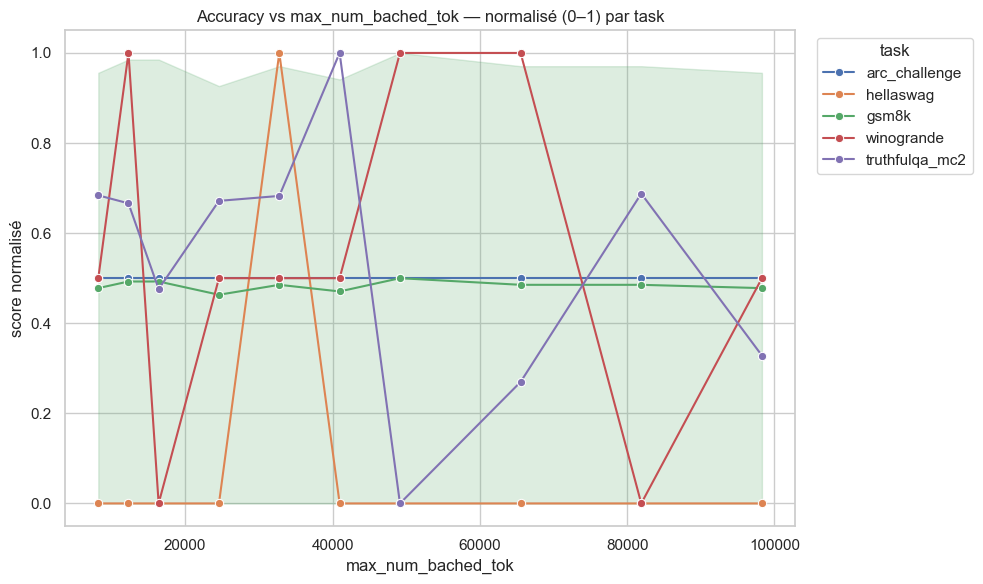

In [469]:
acc_plot = acc_keep.copy()

# normalisation min-max par task
acc_plot["value_norm"] = acc_plot.groupby("task")["value"].transform(
    lambda s: (s - s.min()) / (s.max() - s.min()) if (s.max() - s.min()) != 0 else 0.5
)

plt.figure(figsize=(10,6))
sns.lineplot(
    data=acc_plot.sort_values("max_num_bached_tok"),
    x="max_num_bached_tok", y="value_norm",
    hue="task",
    marker="o"
)
plt.title("Accuracy vs max_num_bached_tok — normalisé (0–1) par task")
plt.xlabel("max_num_bached_tok")
plt.ylabel("score normalisé")
plt.legend(title="task", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()



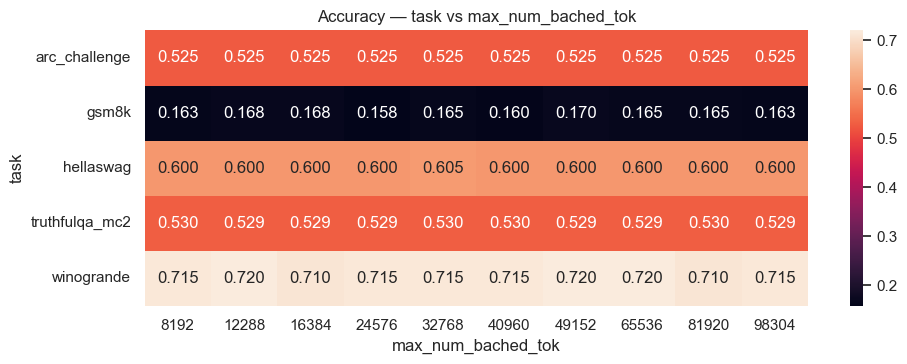

In [470]:
heat = acc_keep.pivot_table(index="task", columns="max_num_bached_tok", values="value", aggfunc="mean")
plt.figure(figsize=(10,3.8))
sns.heatmap(heat, annot=True, fmt=".3f", cbar=True)
plt.title("Accuracy — task vs max_num_bached_tok")
plt.xlabel("max_num_bached_tok")
plt.ylabel("task")
plt.tight_layout()
plt.show()


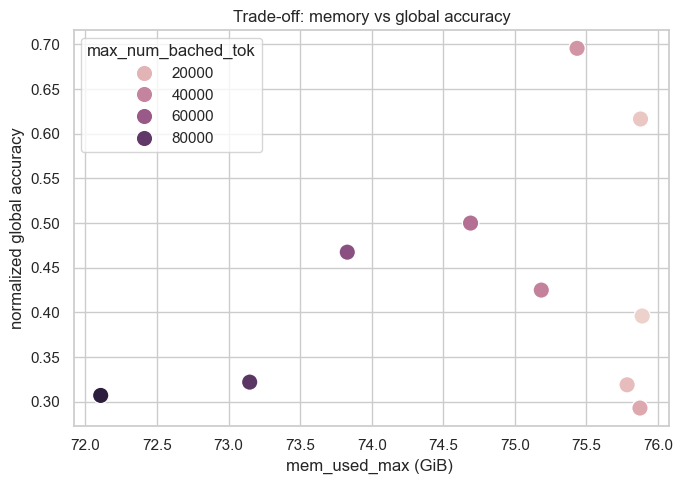

In [471]:
# wide: une colonne par task
acc_wide = acc_keep.pivot_table(index=["run_idx","max_num_bached_tok"], columns="task", values="value", aggfunc="mean")

# normalisation min-max par task (pour comparer des métriques différentes)
acc_norm = (acc_wide - acc_wide.min()) / (acc_wide.max() - acc_wide.min())
acc_norm["acc_global_norm"] = acc_norm.mean(axis=1)

acc_global = acc_norm["acc_global_norm"].reset_index()

trade = mem_run.merge(acc_global, on=["run_idx","max_num_bached_tok"], how="inner").sort_values("mem_max_GiB")

plt.figure(figsize=(7,5))
sns.scatterplot(data=trade, x="mem_max_GiB", y="acc_global_norm", hue="max_num_bached_tok", s=140)
plt.title("Trade-off: memory vs global accuracy")
plt.xlabel("mem_used_max (GiB) ")
plt.ylabel("normalized global accuracy")
plt.tight_layout()
plt.show()


# Enable_chunked_prefill

In [478]:
ROOT = Path(".").resolve()
RUNS_DIR = ROOT / "runs_enable_chunked_prefill"
assert RUNS_DIR.exists(), f"Impossible de trouver {RUNS_DIR}"

def extract_run_id(path: Path) -> int:
    m = re.search(r"(\d+)", path.name)
    if not m:
        raise ValueError(f"Pas de chiffre dans le nom du dossier: {path.name}")
    return int(m.group(1))

# --- 1) Forcer les 10 runs attendus: 1..3 ---
target_run_ids = list(range(1, 3))  # 1..3 inclus
run_dirs = [d for d in RUNS_DIR.iterdir() if d.is_dir() and extract_run_id(d) in target_run_ids]
run_dirs = sorted(run_dirs, key=extract_run_id)

run_ids = [extract_run_id(d) for d in run_dirs]
print("Runs détectés (run_id):", run_ids)
assert run_ids == target_run_ids, f"Attention: runs attendus {target_run_ids} mais trouvés {run_ids}"

# --- 2) Mapping run_idx -> max_num_seq ---
enable_chunked_prefill = ["ON","OFF"]

meta = pd.DataFrame({
    "run_dir": run_dirs,
    "run_id": run_ids,
    "run_idx": list(range(1, 3)),
    "enable_chunked_prefill": enable_chunked_prefill
})

# --- 3) Helpers de lecture ---
def read_csv_with_meta(path: Path, r):
    df = pd.read_csv(path)

    # écraser/ajouter sans erreur même si les colonnes existent déjà
    df["run_id"] = int(r["run_id"])
    df["run_idx"] = int(r["run_idx"])
    df["enable_chunked_prefill"] = str(r["enable_chunked_prefill"])

    # remettre les 3 colonnes en tête
    front = ["run_id", "run_idx", "enable_chunked_prefill"]
    df = df[front + [c for c in df.columns if c not in front]]
    return df


def build_df_fixed(filename: str):
    parts = []
    missing = []
    for _, r in meta.iterrows():
        f = Path(r["run_dir"]) / filename
        if not f.exists():
            missing.append((r["run_id"], str(f)))
            continue
        parts.append(read_csv_with_meta(f, r))
    df = pd.concat(parts, ignore_index=True) if parts else pd.DataFrame()
    return df, missing

def build_df_memory():
    parts = []
    missing = []
    for _, r in meta.iterrows():
        # on cherche le fichier mémoire correspondant au run_id
        expected = f"memory-GPT-run-{r['run_id']}.csv"
        f = Path(r["run_dir"]) / expected

        # fallback si jamais le nom diffère légèrement
        if not f.exists():
            candidates = list(Path(r["run_dir"]).glob("memory-GPT-run-*.csv"))
            # essayer de matcher le run_id dans le nom
            pick = None
            for c in candidates:
                m = re.search(r"memory-GPT-run-(\d+)\.csv$", c.name)
                if m and int(m.group(1)) == int(r["run_id"]):
                    pick = c
                    break
            f = pick if pick else f

        if not f.exists():
            missing.append((r["run_id"], str(f)))
            continue

        parts.append(read_csv_with_meta(f, r))

    df = pd.concat(parts, ignore_index=True) if parts else pd.DataFrame()
    return df, missing

# --- 4) Construire les 4 DF ---
accuracy_df, miss_acc = build_df_fixed("accuracy_metrics.csv")
perf_df,     miss_perf = build_df_fixed("perf_full.csv")
memsum_df,   miss_memsum = build_df_fixed("memory_summary.csv")
memory_df,   miss_memory = build_df_memory()

dfs_by_csv = {
    "accuracy_metrics": accuracy_df,
    "perf_full": perf_df,
    "memory_summary": memsum_df,
}


Runs détectés (run_id): [1, 2]


In [479]:
perf_df = dfs_by_csv["perf_full"]
accuracy_df = dfs_by_csv["accuracy_metrics"]
mem_sum_df = dfs_by_csv["memory_summary"]

In [480]:
# 1) Split metric -> metric_name + filter_name
accuracy_df = accuracy_df.copy()
tmp = accuracy_df["metric"].astype(str).str.split(",", n=1, expand=True)

accuracy_df["metric_name"] = tmp[0].str.strip()
accuracy_df["filter_name"] = tmp[1].fillna("").str.strip()

# 2) Label court pour plots (lisible)
metric_short_map = {
    "acc": "acc",
    "acc_norm": "acc_norm",
    "acc_stderr": "acc_se",
    "acc_norm_stderr": "acc_norm_se",
    "exact_match": "em",
    "exact_match_stderr": "em_se",
}

filter_short_map = {
    "none": "",
    "strict-match": "strict",
    "flexible-extract": "flex",
    "strict-match ": "strict",
    "flexible-extract ": "flex",
}

accuracy_df["metric_short"] = accuracy_df["metric_name"].map(metric_short_map).fillna(accuracy_df["metric_name"])
accuracy_df["filter_short"] = accuracy_df["filter_name"].map(filter_short_map).fillna(accuracy_df["filter_name"])

# ex: "acc_norm" ou "em_flex" etc.
accuracy_df["metric_plot"] = (
    accuracy_df["metric_short"]
    + accuracy_df["filter_short"].replace("", pd.NA).radd("_").fillna("")
)

# 3) Optionnel: ordre pour plots
metric_order = ["acc", "acc_norm", "acc_se", "acc_norm_se", "em", "em_flex", "em_se", "em_se_flex"]
accuracy_df["metric_plot"] = pd.Categorical(accuracy_df["metric_plot"], categories=metric_order, ordered=True)


C:\Users\badis\AppData\Local\Temp\ipykernel_29648\1912899128.py:37: Pandas4Warning: Constructing a Categorical with a dtype and values containing non-null entries not in that dtype's categories is deprecated and will raise in a future version.
  accuracy_df["metric_plot"] = pd.Categorical(accuracy_df["metric_plot"], categories=metric_order, ordered=True)


In [ ]:
perf_df.drop(["run_id", "endpoint", "mode","model","probe_n_requests","probe_concurrency","probe_timeout_s",
              "sum_total_tokens","sum_completion_tokens","ok","failed","probe_max_tokens","sum_prompt_tokens"], axis=1, inplace=True)
mem_sum_df.drop(["run_id","util_p95_pct","mem_total_MiB","util_max_pct","source_file"], axis=1, inplace=True)
accuracy_df.drop(["run_id","metric","metric_plot","filter_short","metric_short","filter_name"], axis=1, inplace=True)

In [482]:
sns.set_theme(style="whitegrid")

# ---------- MEMORY (run-level) ----------
mem_run = (
    mem_sum_df
    .groupby(["run_idx","enable_chunked_prefill"], as_index=False)
    .agg(
        mem_used_max_MiB=("mem_used_max_MiB","max"),   # worst GPU
        mem_used_mean_MiB=("mem_used_mean_MiB","mean") # avg over GPUs
    )
)
mem_run["mem_max_GiB"]  = mem_run["mem_used_max_MiB"] / 1024
mem_run["mem_mean_GiB"] = mem_run["mem_used_mean_MiB"] / 1024


# ---------- ACCURACY : garder les métriques "principales" ----------
acc = accuracy_df.copy()

# Si jamais tu as aussi filter_name (selon ton split précédent), on le garde ; sinon on met "none"
if "filter_name" not in acc.columns:
    acc["filter_name"] = "none"

# enlever stderr
acc_main = acc[~acc["metric_name"].str.contains("stderr", na=False)].copy()

# choix des métriques par task:
# - arc_challenge : acc_norm
# - hellaswag     : acc_norm
# - gsm8k         : exact_match (flex si dispo sinon strict si dispo sinon exact_match)
# - truthfulqa_mc2: acc
# - winogrande    : acc

def pick_gsm_filter(df):
    if (df["filter_name"] == "flexible-extract").any():
        return "flexible-extract"
    if (df["filter_name"] == "strict-match").any():
        return "strict-match"
    return df["filter_name"].iloc[0]  # fallback

gsm_filter = pick_gsm_filter(
    acc_main[(acc_main.task=="gsm8k") & (acc_main.metric_name=="exact_match")]
) if ((acc_main.task=="gsm8k") & (acc_main.metric_name=="exact_match")).any() else "none"

acc_keep = pd.concat([
    acc_main[(acc_main.task=="arc_challenge")  & (acc_main.metric_name=="acc_norm")],
    acc_main[(acc_main.task=="hellaswag")      & (acc_main.metric_name=="acc_norm")],
    acc_main[(acc_main.task=="gsm8k")          & (acc_main.metric_name=="exact_match") & (acc_main.filter_name==gsm_filter)],
    acc_main[(acc_main.task=="truthfulqa_mc2") & (acc_main.metric_name=="acc")],
    acc_main[(acc_main.task=="winogrande")     & (acc_main.metric_name=="acc")],
], ignore_index=True)


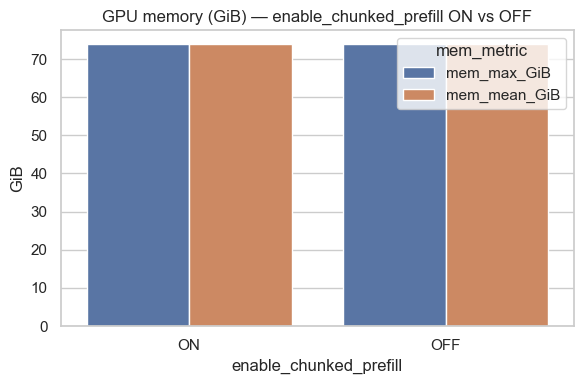

In [493]:
mem_plot = mem_run.copy()
mem_long = mem_plot.melt(
    id_vars=["enable_chunked_prefill"],
    value_vars=["mem_max_GiB","mem_mean_GiB"],
    var_name="mem_metric",
    value_name="GiB"
)

plt.figure(figsize=(6,4))
sns.barplot(data=mem_long, x="enable_chunked_prefill", y="GiB", hue="mem_metric")
plt.title("GPU memory (GiB) — enable_chunked_prefill ON vs OFF")
plt.xlabel("enable_chunked_prefill")
plt.ylabel("GiB")
plt.tight_layout()
plt.show()


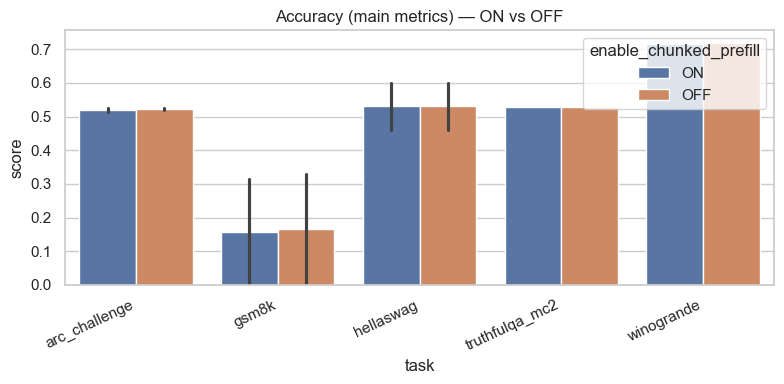

In [494]:
plt.figure(figsize=(8,4))
sns.barplot(
    data=acc_main,
    x="task", y="value",
    hue="enable_chunked_prefill"
)
plt.title("Accuracy (main metrics) — ON vs OFF")
plt.xlabel("task")
plt.ylabel("score")
plt.xticks(rotation=25, ha="right")
plt.tight_layout()
plt.show()


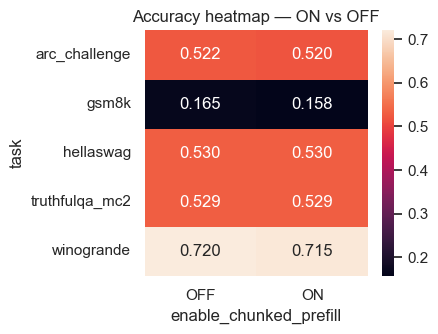

In [495]:
heat = acc_main.pivot_table(index="task", columns="enable_chunked_prefill", values="value", aggfunc="mean")

plt.figure(figsize=(4.5,3.5))
sns.heatmap(heat, annot=True, fmt=".3f", cbar=True)
plt.title("Accuracy heatmap — ON vs OFF")
plt.tight_layout()
plt.show()


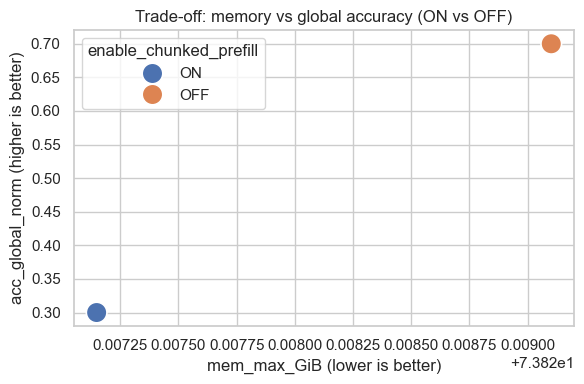

In [496]:
# score global: moyenne des tasks après normalisation par task (ON/OFF)
w = acc_main.pivot_table(index=["enable_chunked_prefill"], columns="task", values="value", aggfunc="mean")
w_norm = (w - w.min()) / (w.max() - w.min())
w_norm = w_norm.fillna(0.5)  # si une task est identique ON/OFF
acc_global = w_norm.mean(axis=1).reset_index(name="acc_global_norm")

trade = mem_run.merge(acc_global, on="enable_chunked_prefill", how="inner")

plt.figure(figsize=(6,4))
sns.scatterplot(data=trade, x="mem_max_GiB", y="acc_global_norm", hue="enable_chunked_prefill", s=220)
plt.title("Trade-off: memory vs global accuracy (ON vs OFF)")
plt.xlabel("mem_max_GiB (lower is better)")
plt.ylabel("acc_global_norm (higher is better)")
plt.tight_layout()
plt.show()


In [497]:
# delta mémoire
mem_delta = mem_run.set_index("enable_chunked_prefill")[["mem_max_GiB","mem_mean_GiB"]]
mem_delta = (mem_delta.loc["OFF"] - mem_delta.loc["ON"]).rename("OFF_minus_ON").to_frame()

# delta accuracy (par task)
acc_delta = (
    acc_main.pivot_table(index="task", columns="enable_chunked_prefill", values="value", aggfunc="mean")
)
acc_delta["OFF_minus_ON"] = acc_delta["OFF"] - acc_delta["ON"]

print("Memory delta (OFF - ON):")
display(mem_delta)

print("Accuracy delta per task (OFF - ON):")
display(acc_delta[["ON","OFF","OFF_minus_ON"]])


Memory delta (OFF - ON):


,OFF_minus_ON
mem_max_GiB,0.001953
mem_mean_GiB,0.001099


Accuracy delta per task (OFF - ON):


enable_chunked_prefill,ON,OFF,OFF_minus_ON
task,,,
arc_challenge,0.520000,0.522500,0.002500
gsm8k,0.157500,0.165000,0.007500
hellaswag,0.530000,0.530000,0.000000
truthfulqa_mc2,0.529498,0.529119,-0.000379
winogrande,0.715000,0.720000,0.005000


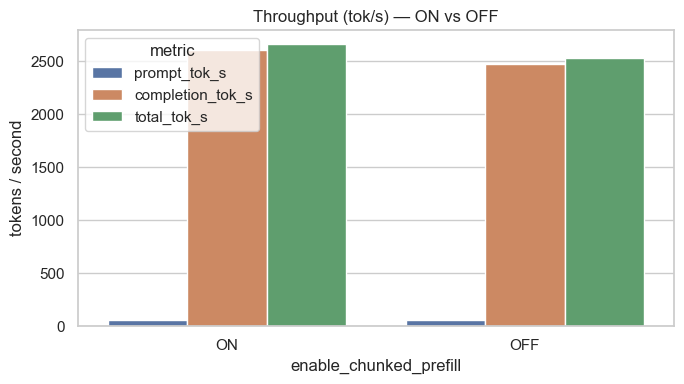

In [500]:
p = perf_df.copy()

tok_long = p.melt(
    id_vars=["enable_chunked_prefill"],
    value_vars=["prompt_tok_s","completion_tok_s","total_tok_s"],
    var_name="metric",
    value_name="tok_s"
)

plt.figure(figsize=(7,4))
sns.barplot(data=tok_long, x="enable_chunked_prefill", y="tok_s", hue="metric")
plt.title("Throughput (tok/s) — ON vs OFF")
plt.xlabel("enable_chunked_prefill")
plt.ylabel("tokens / second")
plt.tight_layout()
plt.show()

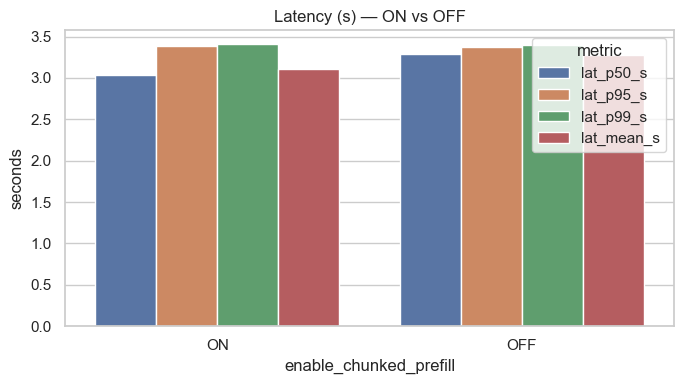

In [501]:
# ---------- 2) Latences : barplot ----------
lat_long = p.melt(
    id_vars=["enable_chunked_prefill"],
    value_vars=["lat_p50_s","lat_p95_s","lat_p99_s","lat_mean_s"],
    var_name="metric",
    value_name="lat_s"
)

plt.figure(figsize=(7,4))
sns.barplot(data=lat_long, x="enable_chunked_prefill", y="lat_s", hue="metric")
plt.title("Latency (s) — ON vs OFF")
plt.xlabel("enable_chunked_prefill")
plt.ylabel("seconds")
plt.tight_layout()
plt.show()

In [502]:
# ---------- 3) Tableau delta (%) OFF vs ON ----------
def pct_change(off, on):
    return (off - on) / on * 100 if on != 0 else float("nan")

on = p.set_index("enable_chunked_prefill").loc["ON"]
off = p.set_index("enable_chunked_prefill").loc["OFF"]

summary = pd.DataFrame({
    "metric": ["total_tok_s","completion_tok_s","prompt_tok_s","lat_p50_s","lat_p95_s","lat_p99_s","lat_mean_s","wall_time_s"],
    "ON": [on["total_tok_s"], on["completion_tok_s"], on["prompt_tok_s"], on["lat_p50_s"], on["lat_p95_s"], on["lat_p99_s"], on["lat_mean_s"], on["wall_time_s"]],
    "OFF": [off["total_tok_s"], off["completion_tok_s"], off["prompt_tok_s"], off["lat_p50_s"], off["lat_p95_s"], off["lat_p99_s"], off["lat_mean_s"], off["wall_time_s"]],
})

summary["OFF_minus_ON"] = summary["OFF"] - summary["ON"]
summary["OFF_vs_ON_%"]  = summary.apply(lambda r: pct_change(r["OFF"], r["ON"]), axis=1)

summary

,metric,ON,OFF,OFF_minus_ON,OFF_vs_ON_%
0,total_tok_s,2659.843088,2527.903093,-131.939995,-4.960443
1,completion_tok_s,2603.899926,2474.734959,-129.164966,-4.960443
2,prompt_tok_s,55.943162,53.168134,-2.775029,-4.960443
3,lat_p50_s,3.032010,3.292686,0.260676,8.597462
4,lat_p95_s,3.383452,3.380126,-0.003327,-0.098329
5,lat_p99_s,3.404974,3.402305,-0.002669,-0.078395
6,lat_mean_s,3.113784,3.280260,0.166477,5.346441
7,wall_time_s,15.730251,16.551267,0.821016,5.219345


# Comparaison avant et apres opti

In [512]:
ROOT = Path(".").resolve()
RUNS_DIR = ROOT / "runs_first_and_last"
assert RUNS_DIR.exists(), f"Impossible de trouver {RUNS_DIR}"

def extract_run_id(path: Path) -> int:
    m = re.search(r"(\d+)", path.name)
    if not m:
        raise ValueError(f"Pas de chiffre dans le nom du dossier: {path.name}")
    return int(m.group(1))

# --- 1) Forcer les 10 runs attendus: 1..3 ---
target_run_ids = list(range(0, 2))  # 1..3 inclus
run_dirs = [d for d in RUNS_DIR.iterdir() if d.is_dir() and extract_run_id(d) in target_run_ids]
run_dirs = sorted(run_dirs, key=extract_run_id)

run_ids = [extract_run_id(d) for d in run_dirs]
print("Runs détectés (run_id):", run_ids)
assert run_ids == target_run_ids, f"Attention: runs attendus {target_run_ids} mais trouvés {run_ids}"



meta = pd.DataFrame({
    "run_dir": run_dirs,
    "run_id": run_ids,
    "run_idx": list(range(0, 2)),
})

# --- 3) Helpers de lecture ---
def read_csv_with_meta(path: Path, r):
    df = pd.read_csv(path)

    # écraser/ajouter sans erreur même si les colonnes existent déjà
    df["run_id"] = int(r["run_id"])
    df["run_idx"] = int(r["run_idx"])

    # remettre les 3 colonnes en tête
    front = ["run_id", "run_idx"]
    df = df[front + [c for c in df.columns if c not in front]]
    return df


def build_df_fixed(filename: str):
    parts = []
    missing = []
    for _, r in meta.iterrows():
        f = Path(r["run_dir"]) / filename
        if not f.exists():
            missing.append((r["run_id"], str(f)))
            continue
        parts.append(read_csv_with_meta(f, r))
    df = pd.concat(parts, ignore_index=True) if parts else pd.DataFrame()
    return df, missing

def build_df_memory():
    parts = []
    missing = []
    for _, r in meta.iterrows():
        # on cherche le fichier mémoire correspondant au run_id
        expected = f"memory-GPT-run-{r['run_id']}.csv"
        f = Path(r["run_dir"]) / expected

        # fallback si jamais le nom diffère légèrement
        if not f.exists():
            candidates = list(Path(r["run_dir"]).glob("memory-GPT-run-*.csv"))
            # essayer de matcher le run_id dans le nom
            pick = None
            for c in candidates:
                m = re.search(r"memory-GPT-run-(\d+)\.csv$", c.name)
                if m and int(m.group(1)) == int(r["run_id"]):
                    pick = c
                    break
            f = pick if pick else f

        if not f.exists():
            missing.append((r["run_id"], str(f)))
            continue

        parts.append(read_csv_with_meta(f, r))

    df = pd.concat(parts, ignore_index=True) if parts else pd.DataFrame()
    return df, missing

# --- 4) Construire les 4 DF ---
accuracy_df, miss_acc = build_df_fixed("accuracy_metrics.csv")
perf_df,     miss_perf = build_df_fixed("perf_full.csv")
memsum_df,   miss_memsum = build_df_fixed("memory_summary.csv")
memory_df,   miss_memory = build_df_memory()

dfs_by_csv = {
    "accuracy_metrics": accuracy_df,
    "perf_full": perf_df,
    "memory_summary": memsum_df,
}


Runs détectés (run_id): [0, 1]


In [513]:
perf_df = dfs_by_csv["perf_full"]
accuracy_df = dfs_by_csv["accuracy_metrics"]
mem_sum_df = dfs_by_csv["memory_summary"]


In [514]:
# 1) Split metric -> metric_name + filter_name
accuracy_df = accuracy_df.copy()
tmp = accuracy_df["metric"].astype(str).str.split(",", n=1, expand=True)

accuracy_df["metric_name"] = tmp[0].str.strip()
accuracy_df["filter_name"] = tmp[1].fillna("").str.strip()

# 2) Label court pour plots (lisible)
metric_short_map = {
    "acc": "acc",
    "acc_norm": "acc_norm",
    "acc_stderr": "acc_se",
    "acc_norm_stderr": "acc_norm_se",
    "exact_match": "em",
    "exact_match_stderr": "em_se",
}

filter_short_map = {
    "none": "",
    "strict-match": "strict",
    "flexible-extract": "flex",
    "strict-match ": "strict",
    "flexible-extract ": "flex",
}

accuracy_df["metric_short"] = accuracy_df["metric_name"].map(metric_short_map).fillna(accuracy_df["metric_name"])
accuracy_df["filter_short"] = accuracy_df["filter_name"].map(filter_short_map).fillna(accuracy_df["filter_name"])

# ex: "acc_norm" ou "em_flex" etc.
accuracy_df["metric_plot"] = (
    accuracy_df["metric_short"]
    + accuracy_df["filter_short"].replace("", pd.NA).radd("_").fillna("")
)

# 3) Optionnel: ordre pour plots
metric_order = ["acc", "acc_norm", "acc_se", "acc_norm_se", "em", "em_flex", "em_se", "em_se_flex"]
accuracy_df["metric_plot"] = pd.Categorical(accuracy_df["metric_plot"], categories=metric_order, ordered=True)


C:\Users\badis\AppData\Local\Temp\ipykernel_29648\1912899128.py:37: Pandas4Warning: Constructing a Categorical with a dtype and values containing non-null entries not in that dtype's categories is deprecated and will raise in a future version.
  accuracy_df["metric_plot"] = pd.Categorical(accuracy_df["metric_plot"], categories=metric_order, ordered=True)


In [515]:
perf_df.drop(["run_id", "endpoint", "mode","model","probe_n_requests","probe_concurrency","probe_timeout_s",
              "sum_total_tokens","sum_completion_tokens","ok","failed","probe_max_tokens","sum_prompt_tokens"], axis=1, inplace=True)
mem_sum_df.drop(["run_id","util_p95_pct","mem_total_MiB","util_max_pct","source_file"], axis=1, inplace=True)
accuracy_df.drop(["run_id","metric","metric_plot","filter_short","metric_short","filter_name"], axis=1, inplace=True)

In [516]:
sns.set_theme(style="whitegrid")

# ---------- MEMORY (run-level) ----------
mem_run = (
    mem_sum_df
    .groupby(["run_idx"], as_index=False)
    .agg(
        mem_used_max_MiB=("mem_used_max_MiB","max"),   # worst GPU
        mem_used_mean_MiB=("mem_used_mean_MiB","mean") # avg over GPUs
    )
)
mem_run["mem_max_GiB"]  = mem_run["mem_used_max_MiB"] / 1024
mem_run["mem_mean_GiB"] = mem_run["mem_used_mean_MiB"] / 1024


# ---------- ACCURACY : garder les métriques "principales" ----------
acc = accuracy_df.copy()

# Si jamais tu as aussi filter_name (selon ton split précédent), on le garde ; sinon on met "none"
if "filter_name" not in acc.columns:
    acc["filter_name"] = "none"

# enlever stderr
acc_main = acc[~acc["metric_name"].str.contains("stderr", na=False)].copy()

# choix des métriques par task:
# - arc_challenge : acc_norm
# - hellaswag     : acc_norm
# - gsm8k         : exact_match (flex si dispo sinon strict si dispo sinon exact_match)
# - truthfulqa_mc2: acc
# - winogrande    : acc

def pick_gsm_filter(df):
    if (df["filter_name"] == "flexible-extract").any():
        return "flexible-extract"
    if (df["filter_name"] == "strict-match").any():
        return "strict-match"
    return df["filter_name"].iloc[0]  # fallback

gsm_filter = pick_gsm_filter(
    acc_main[(acc_main.task=="gsm8k") & (acc_main.metric_name=="exact_match")]
) if ((acc_main.task=="gsm8k") & (acc_main.metric_name=="exact_match")).any() else "none"

acc_keep = pd.concat([
    acc_main[(acc_main.task=="arc_challenge")  & (acc_main.metric_name=="acc_norm")],
    acc_main[(acc_main.task=="hellaswag")      & (acc_main.metric_name=="acc_norm")],
    acc_main[(acc_main.task=="gsm8k")          & (acc_main.metric_name=="exact_match") & (acc_main.filter_name==gsm_filter)],
    acc_main[(acc_main.task=="truthfulqa_mc2") & (acc_main.metric_name=="acc")],
    acc_main[(acc_main.task=="winogrande")     & (acc_main.metric_name=="acc")],
], ignore_index=True)


In [528]:
RUN_BEFORE = 0
RUN_AFTER  = 1

def pct_change(after, before):
    # % change = (after - before) / before * 100
    # gère before=0
    if pd.isna(before) or before == 0:
        return np.nan
    return (after - before) / before * 100

def make_delta_table_single_row(df, metrics, run_col="run_idx", before=RUN_BEFORE, after=RUN_AFTER):
    b = df[df[run_col]==before].iloc[0]
    a = df[df[run_col]==after].iloc[0]

    rows = []
    for m in metrics:
        before_v = float(b[m])
        after_v  = float(a[m])
        rows.append({
            "metric": m,
            "before": before_v,
            "after": after_v,
            "after_minus_before": after_v - before_v,
            "after_vs_before_%": pct_change(after_v, before_v),
        })
    return pd.DataFrame(rows)


In [529]:
# -------------------------
# 1) PERF (% evolution)
# -------------------------
perf_metrics = [
    "lat_p50_s","lat_p95_s","lat_p99_s","lat_mean_s",
    "wall_time_s",
    "prompt_tok_s","completion_tok_s","total_tok_s"
]
perf_delta = make_delta_table_single_row(perf_df, perf_metrics)
perf_delta

,metric,before,after,after_minus_before,after_vs_before_%
0,lat_p50_s,3.494243,3.032010,-0.462233,-13.228410
1,lat_p95_s,3.751714,3.383452,-0.368261,-9.815817
2,lat_p99_s,3.968110,3.404974,-0.563136,-14.191550
3,lat_mean_s,3.465879,3.113784,-0.352095,-10.158896
4,wall_time_s,18.369597,15.730251,-2.639346,-14.368013
5,prompt_tok_s,47.905241,55.943162,8.037921,16.778792
6,completion_tok_s,2229.771240,2603.899926,374.128686,16.778792
7,total_tok_s,2277.676481,2659.843088,382.166607,16.778792


In [530]:
# -------------------------
# 2) MEMORY (% evolution)
# -------------------------
mem_metrics = ["mem_used_max_MiB","mem_used_mean_MiB","mem_max_GiB","mem_mean_GiB"]
mem_delta = make_delta_table_single_row(mem_run, mem_metrics)
mem_delta

,metric,before,after,after_minus_before,after_vs_before_%
0,mem_used_max_MiB,79929.000000,75599.000000,-4330.000000,-5.417308
1,mem_used_mean_MiB,79928.605263,75597.041667,-4331.563596,-5.419291
2,mem_max_GiB,78.055664,73.827148,-4.228516,-5.417308
3,mem_mean_GiB,78.055279,73.825236,-4.230043,-5.419291


In [531]:
# -------------------------
# 3) ACCURACY (% evolution) — par task
# -------------------------
# On suppose que acc_main contient déjà les métriques principales (acc_norm pour arc/hellaswag etc.)
acc_w = acc_main.pivot_table(index="task", columns="run_idx", values="value", aggfunc="mean")

acc_delta = acc_w.copy()
acc_delta["before"] = acc_delta[RUN_BEFORE]
acc_delta["after"]  = acc_delta[RUN_AFTER]
acc_delta["after_minus_before"] = acc_delta["after"] - acc_delta["before"]
acc_delta["after_vs_before_%"] = (acc_delta["after_minus_before"] / acc_delta["before"]) * 100
acc_delta = acc_delta[["before","after","after_minus_before","after_vs_before_%"]].reset_index()

acc_delta

run_idx,task,before,after,after_minus_before,after_vs_before_%
0,arc_challenge,0.520000,0.520000,0.000000,0.000000
1,gsm8k,0.157500,0.157500,0.000000,0.000000
2,hellaswag,0.532500,0.530000,-0.002500,-0.469484
3,truthfulqa_mc2,0.529591,0.529498,-0.000093,-0.017581
4,winogrande,0.710000,0.715000,0.005000,0.704225


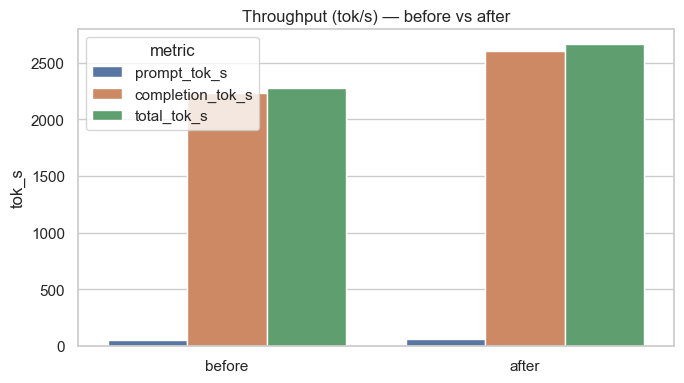

In [532]:
p = perf_df.copy()
p["stage"] = p["run_idx"].map({0:"before", 1:"after"})

tok_long = p.melt(id_vars="stage",
                  value_vars=["prompt_tok_s","completion_tok_s","total_tok_s"],
                  var_name="metric", value_name="tok_s")

plt.figure(figsize=(7,4))
sns.barplot(data=tok_long, x="stage", y="tok_s", hue="metric")
plt.title("Throughput (tok/s) — before vs after")
plt.xlabel("")
plt.tight_layout()
plt.show()

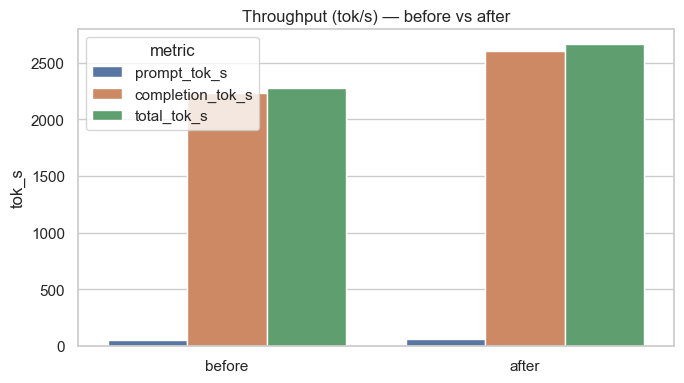

In [533]:
p = perf_df.copy()
p["stage"] = p["run_idx"].map({0:"before", 1:"after"})

tok_long = p.melt(id_vars="stage",
                  value_vars=["prompt_tok_s","completion_tok_s","total_tok_s"],
                  var_name="metric", value_name="tok_s")

plt.figure(figsize=(7,4))
sns.barplot(data=tok_long, x="stage", y="tok_s", hue="metric")
plt.title("Throughput (tok/s) — before vs after")
plt.xlabel("")
plt.tight_layout()
plt.show()

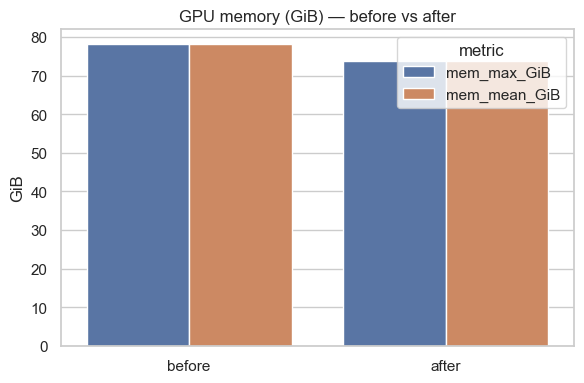

In [534]:
m = mem_run.copy()
m["stage"] = m["run_idx"].map({0:"before", 1:"after"})

mem_long = m.melt(id_vars="stage",
                  value_vars=["mem_max_GiB","mem_mean_GiB"],
                  var_name="metric", value_name="GiB")

plt.figure(figsize=(6,4))
sns.barplot(data=mem_long, x="stage", y="GiB", hue="metric")
plt.title("GPU memory (GiB) — before vs after")
plt.xlabel("")
plt.tight_layout()
plt.show()


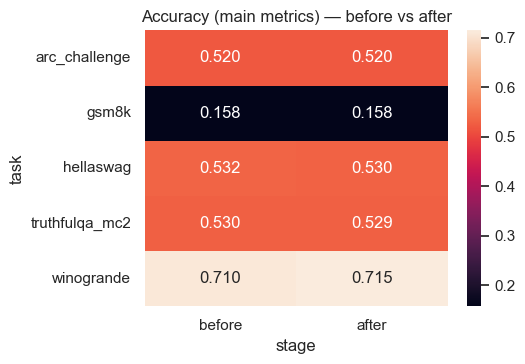

In [535]:
a = acc_main.copy()
a["stage"] = a["run_idx"].map({0:"before", 1:"after"})

heat = a.pivot_table(index="task", columns="stage", values="value", aggfunc="mean")

plt.figure(figsize=(5.5,3.8))
sns.heatmap(heat[["before","after"]], annot=True, fmt=".3f", cbar=True)
plt.title("Accuracy (main metrics) — before vs after")
plt.tight_layout()
plt.show()


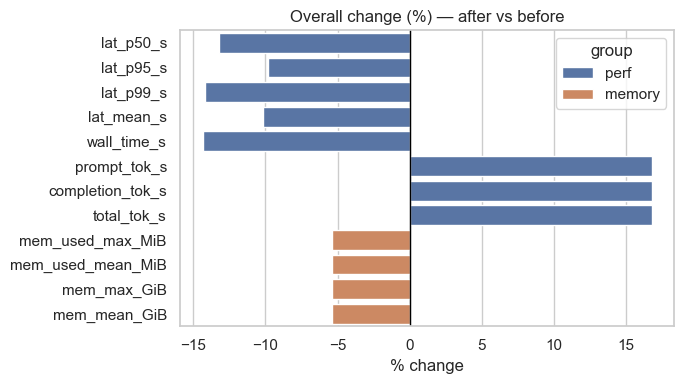

In [536]:
# Utilise tes tables déjà calculées perf_delta et mem_delta (ou refais-les)
# Ici je pars des tableaux que tu as affichés : perf_delta, mem_delta
sum_df = pd.concat([
    perf_delta.assign(group="perf"),
    mem_delta.assign(group="memory"),
], ignore_index=True)

plt.figure(figsize=(7,4))
sns.barplot(data=sum_df, y="metric", x="after_vs_before_%", hue="group")
plt.axvline(0, color="black", linewidth=1)
plt.title("Overall change (%) — after vs before")
plt.xlabel("% change")
plt.ylabel("")
plt.tight_layout()
plt.show()
